![](https://chendongze.oss-cn-shanghai.aliyuncs.com/ipic/ihkvn.png)
# 下载处理后的数据库数据库

In [1]:
# !gdown --id 18x-aCvxJpOrWJoZ5VAuIe-xzNJHH9lqH

In [2]:
# 从用 base 环境


In [3]:
# !unzip pop17.zip -d pop17-dataset

In [4]:
# !pip install miditok miditoolkit tqdm
# !pip install numpy==1.20.3
# !pip install miditok==1.1.4
# !pip install miditoolkit==0.1.15

# !pip install tensorflow_probability==0.14.1
# !pip install tqdm==4.55.1


  Using cached miditok-1.1.4-py3-none-any.whl (57 kB)
ERROR: Could not find a version that satisfies the requirement numpy>=1.21 (from miditok) (from versions: 1.3.0, 1.4.1, 1.5.0, 1.5.1, 1.6.0, 1.6.1, 1.6.2, 1.7.0, 1.7.1, 1.7.2, 1.8.0, 1.8.1, 1.8.2, 1.9.0, 1.9.1, 1.9.2, 1.9.3, 1.10.0.post2, 1.10.1, 1.10.2, 1.10.4, 1.11.0, 1.11.1, 1.11.2, 1.11.3, 1.12.0, 1.12.1, 1.13.0rc1, 1.13.0rc2, 1.13.0, 1.13.1, 1.13.3, 1.14.0rc1, 1.14.0, 1.14.1, 1.14.2, 1.14.3, 1.14.4, 1.14.5, 1.14.6, 1.15.0rc1, 1.15.0rc2, 1.15.0, 1.15.1, 1.15.2, 1.15.3, 1.15.4, 1.16.0rc1, 1.16.0rc2, 1.16.0, 1.16.1, 1.16.2, 1.16.3, 1.16.4, 1.16.5, 1.16.6, 1.17.0rc1, 1.17.0rc2, 1.17.0, 1.17.1, 1.17.2, 1.17.3, 1.17.4, 1.17.5, 1.18.0rc1, 1.18.0, 1.18.1, 1.18.2, 1.18.3, 1.18.4, 1.18.5, 1.19.0rc1, 1.19.0rc2, 1.19.0, 1.19.1, 1.19.2, 1.19.3, 1.19.4, 1.19.5)
ERROR: No matching distribution found for numpy>=1.21


In [5]:
from Model import *
from utils import batch
import math
import random
from dataset import CP_Word_Dataset

## 设置模型与训练参数

In [6]:
train_seq_length = 1025
database_name = 'pop17'
eval_out_path = './pop17-dataset/pop17_eval_dataset.json'
train_out_path = './pop17-dataset/pop17_train_dataset.json'
test_out_path = './pop17-dataset/pop17_test_dataset.json'
log_dir = './tf_logs/'
checkpoint_dir = './hy-tmp/checkpoints/'

In [7]:
# Train

epoch = 1
batch_size = 5
warmup_steps = 4000
save_n_step = 20
setLogs_n_step = 20
save_test_best_n_step = 500
test_start_step = 5000
reset_states_n_step = 20



# [Family Bar/position Pitch Velocity Duration Chord Rest Tempo]

token_range = [2, 34, 89, 33, 65, 18, 10, 33]
emb_sizes = [32, 64, 256, 128, 128, 64, 64, 64]

vocab_sizes = [i+2 for i in token_range]
eos_tokens = [i+1 for i in token_range]

eos_tokens = vocab2token([eos_tokens])[0]
random.seed(1)  # for data

config = {
    "vocab_sizes": vocab_sizes,
    "emb_sizes": emb_sizes,
    "d_model": 128,
    "dff": 1024,
    "num_layers": 4,
    "num_heads": 4,
    "dropout_rate": 0.1,
    "length": 1024,
    "rpr": True,
    "dataset": f'{database_name}_{train_seq_length}',
}

## 初始化模型

In [8]:
mt = model().getLinearTransformerXL(config, log_dir, checkpoint_dir)

## 加载权重

In [9]:
if len(os.listdir(mt.checkpoint_dir)) > 0:
    checkpoint_path = f"{mt.checkpoint_dir}/lastest-ckpt"
    print(f'load:{checkpoint_path}')
    mt.load_weights(checkpoint_path)

load:./hy-tmp/checkpoints/-vocab_sizes4-36-91-35-67-20-12-35-emb_sizes32-64-256-128-128-64-64-64-d_model128-dff1024-num_layers4-num_heads4-dropout_rate0.1-length1024-rprTrue-datasetpop17_1025/lastest-ckpt


# 查看模型

In [10]:
inp = tf.constant([[[1, 1, 1, 1, 1, 1, 1, 1]]], tf.int64)
r, w = mt(inp, True, inp)
mt.summary()

Model: "linear_transformer_xl"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_layer (EncoderLayer) multiple                  362624    
_________________________________________________________________
encoder_layer_1 (EncoderLaye multiple                  362624    
_________________________________________________________________
encoder_layer_2 (EncoderLaye multiple                  362624    
_________________________________________________________________
encoder_layer_3 (EncoderLaye multiple                  362624    
_________________________________________________________________
embedding (Embedding)        multiple                  128       
_________________________________________________________________
embedding_1 (Embedding)      multiple                  2304      
_________________________________________________________________
embedding_2 (Embedding)      multiple        

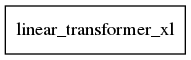

In [13]:
from keras.utils.vis_utils import plot_model
# 输出可视化图片
# 参数：model为你的模型，to_file保存文件名，show_shapes是否显示输入输出尺寸
plot_model(mt, 
           to_file='linear_transformer_xl.png', 
           show_shapes=True,
           show_layer_names=True,

           expand_nested=True,
           dpi=96
          )

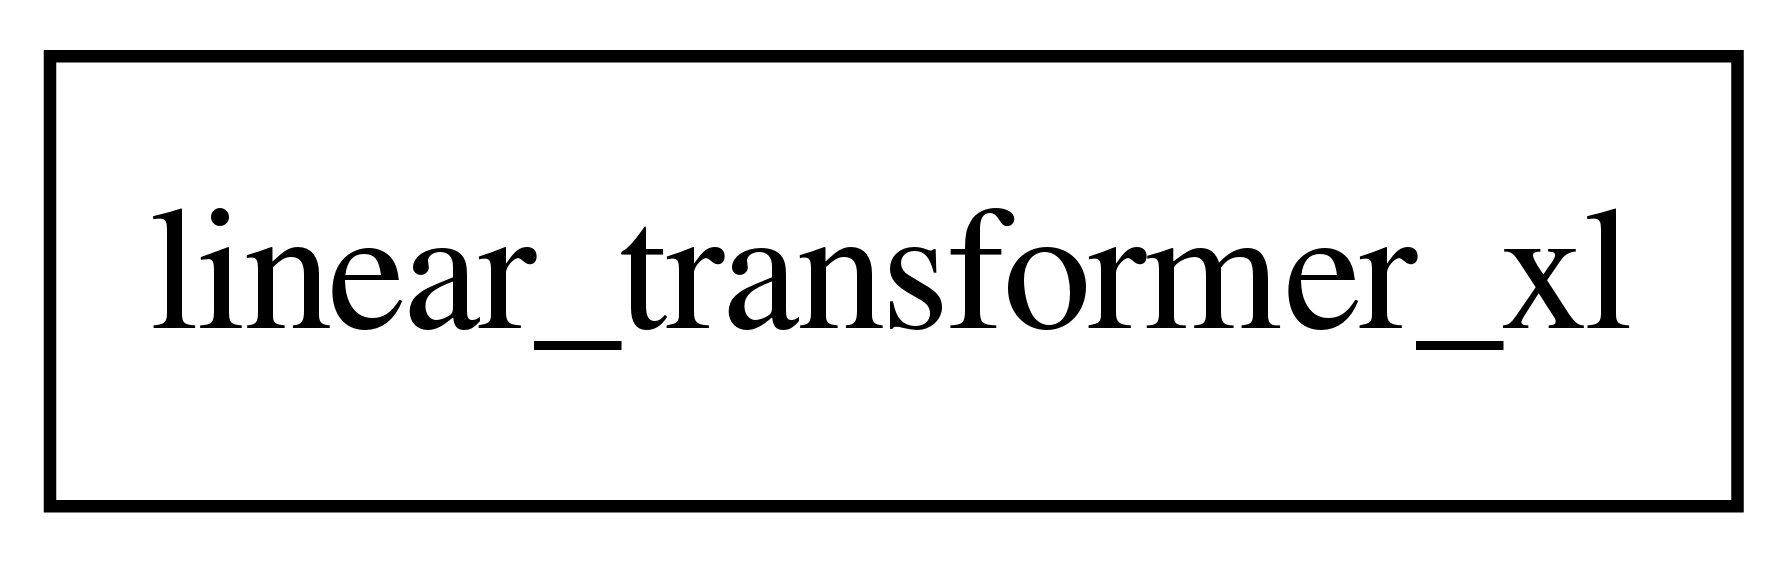

In [14]:
plot_model(mt, to_file='linear_transformer_xl.png', show_shapes=True, show_layer_names=True,rankdir='TB', dpi=900, expand_nested=True)


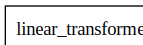

In [15]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(mt).create(prog='dot', format='svg'))
# 【实现不了】
# 此外，你也可以直接取得 pydot.Graph 对象并自己渲染它。
# 例如，ipython notebook 中的可视化实例如下：

In [16]:
# !pip install graphviz
# !pip install pydot

In [17]:
# !pip install pydot_ng
# !pip install pydot

## 存放 run state

In [18]:
train_cache_dir = f'{mt.log_dir}/train_process.json'
train_process_json = Train_process_json(train_cache_dir)

In [19]:
print(train_process_json)

In [20]:
import json
path='data'
f = open(train_cache_dir,'r',encoding='utf-8')
m = json.load(f) # json.load() 这种方法是解析一个文件中的数据
				 # json.loads() 需要先将文件，读到一个变量作为字符串, 解析一个字符串中的数

print(m)

{'step': 15269, 'best_acc': '0.84261805', 'best_loss': '0.49120894'}


## 设置训练信息

In [21]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=warmup_steps):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps
        self.step = 0
        self.lr = 0

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        lr = tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

        self.step = step
        self.lr = lr
        return lr


learning_rate = CustomSchedule(config['d_model'])
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)


def loss_function(real, pred):
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
    accuracies = tf.equal(real, tf.argmax(pred, axis=2))

    mask = tf.math.logical_not(tf.math.equal(real, 0))
    accuracies = tf.math.logical_and(mask, accuracies)

    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)


In [22]:
mt.train_setup(loss_function, accuracy_function,
               optimizer)

## 读取训练状态


In [23]:
best_acc = train_process_json.get()['best_acc']
best_loss = train_process_json.get()['best_loss']
current_step = train_process_json.get()['step']

## 配置tf-logs

In [24]:
stat_names = ['Family', 'Position', 'Pitch',
              'Velocity', 'Duration', 'Chord', 'Rest', 'Tempo', 'Total']
train_losses = [tf.keras.metrics.Mean(
    name=f'{n}_loss') for n in stat_names]
train_accuracy = [tf.keras.metrics.Mean(
    name=f'{n}_accuracy') for n in stat_names]

eval_losses = [tf.keras.metrics.Mean(
    name=f'{n}_loss') for n in stat_names]
eval_accuracy = [tf.keras.metrics.Mean(
    name=f'{n}_accuracy') for n in stat_names]

train_summary_writer = tf.summary.create_file_writer(f'{mt.log_dir}/train_dir')
eval_summary_writer = tf.summary.create_file_writer(f'{mt.log_dir}/eval_dir')
test_summary_writer = tf.summary.create_file_writer(f'{mt.log_dir}/test_dir')


def setLogs():
    step = current_step
    with train_summary_writer.as_default():
        for l in train_losses:
            tf.summary.scalar(l.name, l.result(), step=step)
        for a in train_accuracy:
            tf.summary.scalar(a.name, a.result(), step=step)
    with eval_summary_writer.as_default():
        for l in eval_losses:
            tf.summary.scalar(l.name, l.result(), step=step)
        for a in eval_accuracy:
            tf.summary.scalar(a.name, a.result(), step=step)


def reset_states():
    for t in train_losses:
        t.reset_states()
    for t in train_accuracy:
        t.reset_states()
    for t in eval_losses:
        t.reset_states()
    for t in eval_accuracy:
        t.reset_states()


## 定义 ckpt 保存函数

In [25]:
def save_lastest_ckpt():
    train_process_json.set(current_step, best_acc, best_loss)
    mt.save_weights(
        f'{mt.checkpoint_dir}/lastest-ckpt', overwrite=True, save_format="tf")


def save_test_best_ckpt(loss, acc):
    global best_acc
    global best_loss

    if(acc > best_acc):
        best_acc = acc
        train_process_json.set(current_step, best_acc, best_loss)
        mt.save_weights(
            f'{mt.checkpoint_dir}/best_acc-ckpt{current_step}', overwrite=True, save_format="tf")

    if(loss < best_loss):
        train_process_json.set(current_step, best_acc, best_loss)
        best_loss = loss
        mt.save_weights(
            f'{mt.checkpoint_dir}/best_loss-ckpt{current_step}', overwrite=True, save_format="tf")

    mt.save_weights(f'{mt.checkpoint_dir}/ckpt{current_step}',
                    overwrite=True, save_format="tf")

    with test_summary_writer.as_default():
        tf.summary.scalar('test_loss', loss, step=current_step)
        tf.summary.scalar('test_acc', acc, step=current_step)


## 开始训练

In [26]:
for e in range(epoch):

    eval_ds = CP_Word_Dataset(eval_out_path, train_seq_length, eos_tokens)
    print('eval_ds length', eval_ds.total_seq)

    train_ds = CP_Word_Dataset(train_out_path, train_seq_length, eos_tokens)

    print('train_ds length', train_ds.total_seq)

    test_ds = CP_Word_Dataset(test_out_path, train_seq_length, eos_tokens)

    print('test_ds length', test_ds.total_seq)

    train_step_per_epoch = math.ceil(train_ds.total_seq / batch_size)
    eval_step_per_epoch = math.ceil(eval_ds.total_seq / batch_size)

    current_epoch = math.ceil(current_step / train_step_per_epoch)

    train_data_range_idxs = random.sample(
        range(train_ds.total_seq), train_ds.total_seq)

    eval_data_range_idxs = random.sample(
        range(eval_ds.total_seq), eval_ds.total_seq)

    with tqdm(total=train_step_per_epoch) as bar:
        idx = 0
        train_seq_start_idx = current_step % train_step_per_epoch * batch_size

        for batch_idxs in batch(train_data_range_idxs[train_seq_start_idx:], batch_size):

            # train
            seqs = train_ds.get_seqs(batch_idxs)  # (batch_size, length, 6)
            losses, acc = mt.train_step(np.array(seqs))
            current_step += 1
            current_lr = learning_rate(tf.cast(current_step, tf.float32))

            for i in range(len(losses)):
                train_losses[i](losses[i].numpy())
                train_accuracy[i](acc[i])
            train_losses[-1](np.sum([l.numpy()
                             for l in losses]) / len(losses))  # 均值
            train_accuracy[-1](np.sum(acc) / len(losses))

            # eval
            e_start_idx = current_step % eval_step_per_epoch * batch_size
            eval_batch_idxs = eval_data_range_idxs[e_start_idx: e_start_idx + batch_size]

            eval_seqs = eval_ds.get_seqs(eval_batch_idxs)
            e_losses, e_acc = mt.eval(eval_seqs)

            for i in range(len(losses)):
                eval_losses[i](e_losses[i].numpy())
                eval_accuracy[i](e_acc[i])

            eval_losses[-1](np.sum([l.numpy()
                            for l in e_losses]) / len(e_losses))  # 均值
            eval_accuracy[-1](np.sum(e_acc) / len(e_losses))

            if idx % setLogs_n_step == 0:
                setLogs()

            if idx % save_n_step == 0:
                save_lastest_ckpt()

            # if idx % save_eval_best_n_step == 0:
            #     save_eval_best_ckpt()

            if current_step % save_test_best_n_step == 0 and current_step > test_start_step:
                loss, acc = mt.test(test_ds, batch_size)
                save_test_best_ckpt(loss, acc)

            # [Family Bar/position Pitch Velocity Duration Tempo]
            bar.set_description(
                f'Epoch/step {current_epoch}/{current_step}: lr {float(current_lr):.6}  Loss/eval/best {float(train_losses[-1].result()):.6}/{float(eval_losses[-1].result()):.6}/{best_loss:.6}  Acc/eval/best {float(train_accuracy[-1].result()):.6}/{float(eval_accuracy[-1].result()):.6}/{best_acc:.6}'
            )
            if idx == 0:
                bar.update(current_step % train_step_per_epoch)
            bar.update(1)

            if idx % reset_states_n_step == 0:
                reset_states()
            idx += 1


eval_ds length 9107
train_ds length 76346


  0%|          | 0/15270 [00:00<?, ?it/s]

test_ds length 10404


Epoch/step 1/15270: lr 0.000715279  Loss/eval/best 0.38869/0.488757/0.491209  Acc/eval/best 0.862549/0.844104/0.842618:   0%|          | 1/15270 [00:09<40:52:40,  9.64s/it]


## 生成 MIDI

In [27]:
from dataset import get_tokenizer
import datetime

ckpt = 'lastest-ckpt'

if len(os.listdir(mt.checkpoint_dir)) > 0:
    checkpoint_path = f"{mt.checkpoint_dir}/{ckpt}"
    print(f'load:{checkpoint_path}')
    mt.load_weights(checkpoint_path)

tokenizer = get_tokenizer()
seed_length = 10
length = 500
temperature = [0.05, 0.01, 1, 1, 1.1, 0.01, 1, 0.01]
nucleus_p = [False, 0.9, 0.9, 0.9, 0.95, 0.9, 0.9, 0.9]


if_end = False  # Fasle 为屏蔽 EOS Token



seqs = np.array(eval_ds.get_seqs([0]))
inp = seqs[:batch_size, :seed_length]



gen = mt.generate(np.array(inp), int(length), temperature, nucleus_p, if_end)
tokens = [vocab2token(g) for g in gen]
current_time = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

idx = 0



  0%|          | 0/500 [00:00<?, ?it/s]

load:./hy-tmp/checkpoints/-vocab_sizes4-36-91-35-67-20-12-35-emb_sizes32-64-256-128-128-64-64-64-d_model128-dff1024-num_layers4-num_heads4-dropout_rate0.1-length1024-rprTrue-datasetpop17_1025/lastest-ckpt
miditok warning: CPWordEncoding class has been renamed CPWord and will be removed in future updates, please consider changing it in your code.


100%|██████████| 500/500 [00:49<00:00, 10.04it/s]


In [28]:
# 这边生成的数据是什么样式的？
print(tokens)


[array([[  3,   1,   4, ..., 224, 242, 252],
       [  3,   1,   4, ..., 224, 242, 252],
       [  3, 192,   4, ..., 224, 242, 258],
       ...,
       [  2, 191,  51, ..., 224, 242, 252],
       [  3, 204,   4, ..., 224, 242, 258],
       [  2, 191,  53, ..., 224, 242, 252]])]


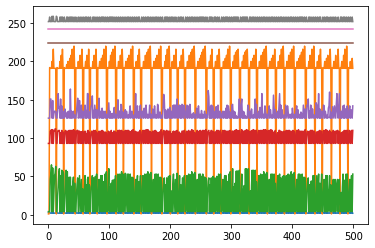

In [29]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
np.random.seed(1000)
y = tokens[0]
# print "y = %s"% y
x = range(len(y))
# print "x=%s"% x
plt.plot(y)
plt.show()

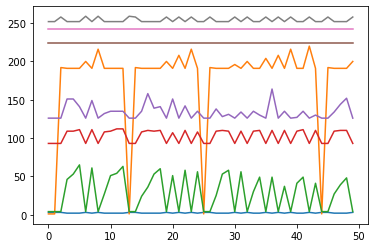

In [30]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
np.random.seed(1000)
y = tokens[0][0:50]
# print "y = %s"% y
x = range(len(y))
# print "x=%s"% x
plt.plot(y)
plt.show()

In [31]:
# [[Tokenizer]] 的主要功能就是将 seqence 转变为一个 id 序列

In [32]:
for midi_token in tokens:
    converted_back_midi = tokenizer.tokens_to_midi(
        np.array([midi_token]), [(0, False)])
    converted_back_midi.dump(
        f'./gen_midi/{idx}-{temperature}-{nucleus_p}-{length}.{current_time}.midi')
    idx += 1

KeyError: 3

# jupyter 插件

In [ ]:
!jupyter labextension list

In [ ]:
!jupyter lab paths

In [ ]:
# 构建失败编译500失败，请在服务器上运行“jupyter lab Build”以获得完整输出
!jupyter lab Build

# tensorboard


In [ ]:
# print(mylogdir)

In [ ]:
!tensorboard --logdir mylogdir

In [ ]:
# !tensorboard --helpfull

In [ ]:
!tensorboard dev upload --logdir \ 'mylogdir' -y